In [1]:
import matplotlib.pyplot as plt
from time import time
from simfunctions import *

import matplotlib as mpl

# Take colors at regular intervals spanning the colormap.
colors = mpl.colormaps['Dark2'].colors

# SIS Model

$$ S + I \to I + I, c_1x_Sx_I $$
$$ S \to I, c_2x_S $$
$$ I \to S, c_3x_I $$
with parameters $c_1 = 0.008, c_2=0.1, c_3 = 0.3$


In [2]:
def rate1(X):
    rate = 0.016*X[0]*X[1]
    if rate > 0:
        return rate
    else:
        return 0

def rate2(X):
    rate = 0.1*X[0]
    if rate > 0:
        return rate
    else:
        return 0
    
def rate3(X):
    rate = 0.5*X[1]
    if rate > 0:
        return rate
    else:
        return 0
    
def jac(X):
    return np.array([[0.008*X[1], 0.008*X[0]], [0.1, 0], [0, 0.5]])

# Example usage:
drift = [rate1, rate2, rate3]
S_matrix = np.array([[-1, 1], [-1, 1], [1, -1]])  # Stoichiometry matrix
c = np.array([1,1,1])  # Reaction rates
X0 = np.array([90, 40])  # Initial state
T = 10  # Total time

## Tau-Leaping

In [3]:
def tau_leaping(drift, S, c, X0, T, tau):
    """
    drift: list of rate functions
    S: Stoichiometry matrix. Each row represents a reaction, and each column represents a species.
    c: Array of reaction rates.
    X0: Initial state.
    T: Total time.
    tau: Leap size.
    """
    steps = int(np.ceil(T/tau))
    K_list = []
    X = []
    t = []
    t0 = 0.
    X.append(X0)
    t.append(t0)
    
    for j in range(steps):
        a = c*np.array([rate(X[j]) for rate in drift])  # Propensity function
        K = np.random.poisson(a*tau)  # Number of reactions
        K_list.append(K)
        X_new = X[j] + np.dot(K, S)  # Update the state
        X.append(X_new)
        t.append(t[j]+tau)

        # Check for negative populations
        if np.any(X[j+1] < 0):
            print('Negative population, restarting run')
            return None, t
        
    return X, t, K_list

0.0 % simulations completed
10.0 % simulations completed
20.0 % simulations completed
30.0 % simulations completed
40.0 % simulations completed
50.0 % simulations completed
60.0 % simulations completed
70.0 % simulations completed
80.0 % simulations completed
90.0 % simulations completed
Number of steps:  51


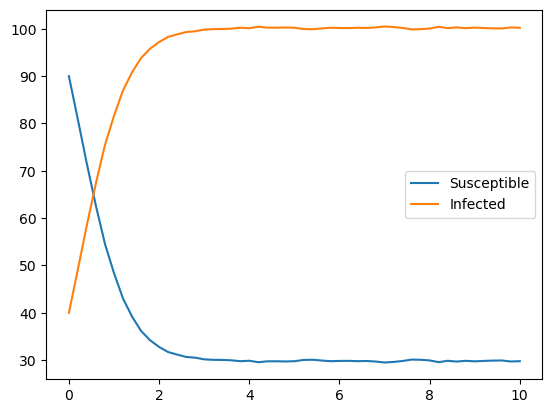

In [4]:
tau = 0.2  # Leap size

n_runs = 1000
runs = []
k_runs = []

for run in range(n_runs):
    if 100*run/n_runs % 10 == 0:
        print(100*run/n_runs, '% simulations completed')
    X = None
    while X is None:
        X, t_tau, K_list = tau_leaping(drift, S_matrix, c, X0, T, tau)
    runs.append(X)
    k_runs.append(K_list)
    
print('Number of steps: ', len(X))

Xs = np.mean(np.array(runs)[:,:,0], axis=0)
Xi = np.mean(np.array(runs)[:,:,1], axis=0)

plt.plot(t_tau, Xs, label='Susceptible')
plt.plot(t_tau, Xi, label='Infected')
plt.legend()

In [5]:
k_last = []

k1_list = []
k2_list = []
k1k2_list = []

for k_run in k_runs:
    k_last.append(k_run[-1])
    
for i in range(len(k_last)):
    k1 = k_last[0]
    k2 = k_last[1]
    k1_list.append(k1)
    k2_list.append(k2)
    k1k2_list.append(k1*k2)
    
np.mean(k1), np.mean(k2), np.mean(k1*k2)-np.mean(k1)*np.mean(k2)

(4.0, 7.0, 14.666666666666664)

## Mean-field

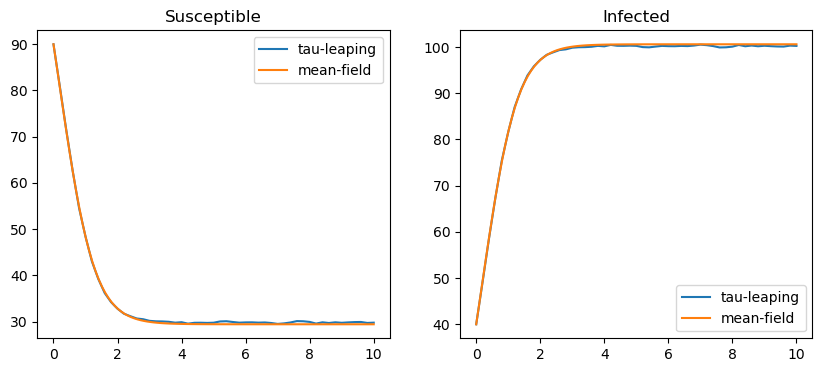

In [6]:
tmf = np.linspace(0,T, 100)
Xmf = mean_field(drift,S_matrix,c,X0,tmf)

fig, axs = plt.subplots(1,2, figsize=(10,4))

axs[0].plot(t_tau, Xs, label='tau-leaping')
axs[0].plot(tmf, Xmf[:,0], label='mean-field')
axs[0].set_title('Susceptible')
axs[0].legend()

axs[1].plot(t_tau, Xi, label='tau-leaping')
axs[1].plot(tmf, Xmf[:,1], label='mean-field')
axs[1].set_title('Infected')
axs[1].legend()

## SOGA - Joint approximation on K

In [7]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *


compiledFile=compile2SOGA('../programs/SOGA/SSA/SIS_joint.soga')
cfg = produce_cfg(compiledFile)
output_dist, dynams = start_SOGA(cfg)

In [8]:
t = len(t_tau)

xs = np.zeros(t)
xi = np.zeros(t)
stds = np.zeros(t)
stdi = np.zeros(t)

for i in range(t):
    idxs = output_dist.var_list.index('susceptible[{}]'.format(i))
    idxi = output_dist.var_list.index('infected[{}]'.format(i))
    xs[i] = output_dist.gm.mean()[idxs]
    stds[i] = np.sqrt(output_dist.gm.cov()[idxs,idxs])
    xi[i] = output_dist.gm.mean()[idxi]
    stdi[i] = np.sqrt(output_dist.gm.cov()[idxi,idxi])

C:\Users\birik\AppData\Local\Temp\ipykernel_23504\1806910929.py:12: RuntimeWarning: invalid value encountered in sqrt
  stds[i] = np.sqrt(output_dist.gm.cov()[idxs,idxs])
C:\Users\birik\AppData\Local\Temp\ipykernel_23504\1806910929.py:14: RuntimeWarning: invalid value encountered in sqrt
  stdi[i] = np.sqrt(output_dist.gm.cov()[idxi,idxi])


Text(0, 0.5, 'Number of individuals')

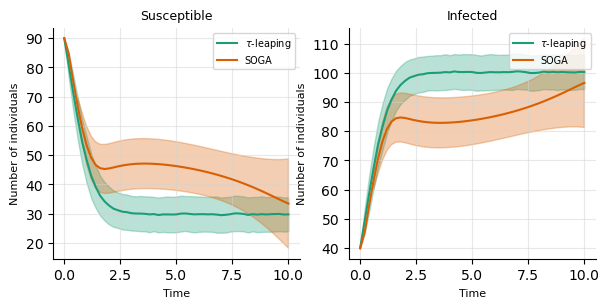

In [9]:
# conditioning on state

fig, axs = plt.subplots(1,2, figsize=(7,3))

stdS = np.std(np.array(runs)[:,:,0], axis=0)
stdI = np.std(np.array(runs)[:,:,1], axis=0)

axs[0].plot(t_tau, Xs, label=r'$\tau$-leaping', color=colors[0])
axs[0].fill_between(t_tau, Xs-stdS, Xs+stdS ,alpha=0.3, color=colors[0])
#axs[0].plot(tmf, Xmf[:,0], label='mean-field', color='green')
axs[0].plot(t_tau, xs, label='SOGA', color=colors[1])
axs[0].fill_between(t_tau, xs-stds, xs+stds ,alpha=0.3, color=colors[1])
axs[0].set_title('Susceptible', fontsize=9)
#axs[0].axhline(0)
axs[0].legend(fontsize = 7)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].grid(color='lightgray', alpha=0.5, zorder=1)
axs[0].set_xlabel('Time', fontsize=8)
axs[0].set_ylabel('Number of individuals', fontsize=8)

axs[1].plot(t_tau, Xi, label=r'$\tau$-leaping', color = colors[0])
axs[1].fill_between(t_tau, Xi-stdI, Xi+stdI, alpha=0.3, color=colors[0])
#axs[1].plot(tmf, Xmf[:,1], label='mean-field', color='green')
axs[1].plot(t_tau, xi, label='SOGA', color=colors[1])
axs[1].fill_between(t_tau, xi-stdi, xi+stdi ,alpha=0.3, color=colors[1])
axs[1].set_title('Infected', fontsize=9)
#axs[1].axhline(0)
axs[1].legend(fontsize = 7)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].grid(color='lightgray', alpha=0.5, zorder=1)
axs[1].set_xlabel('Time', fontsize=8)
axs[1].set_ylabel('Number of individuals', fontsize=8)

In [10]:
xs = np.array(dynams['xs'])
stds = np.sqrt(np.array(dynams['stds']))
xi = np.array(dynams['xi'])
stdi = np.sqrt(np.array(dynams['stdi']))

Text(0, 0.5, 'Number of individuals')

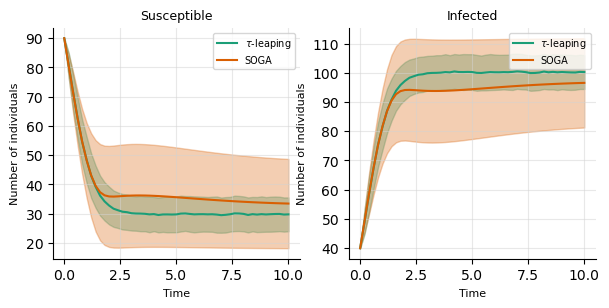

In [11]:
fig, axs = plt.subplots(1,2, figsize=(7,3))

stdS = np.std(np.array(runs)[:,:,0], axis=0)
stdI = np.std(np.array(runs)[:,:,1], axis=0)

axs[0].plot(t_tau, Xs, label=r'$\tau$-leaping', color=colors[0])
axs[0].fill_between(t_tau, Xs-stdS, Xs+stdS ,alpha=0.3, color=colors[0])
#axs[0].plot(tmf, Xmf[:,0], label='mean-field', color='green')
axs[0].plot(t_tau, xs, label='SOGA', color=colors[1])
axs[0].fill_between(t_tau, xs-stds, xs+stds ,alpha=0.3, color=colors[1])
axs[0].set_title('Susceptible', fontsize=9)
#axs[0].axhline(0)
axs[0].legend(fontsize = 7)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].grid(color='lightgray', alpha=0.5, zorder=1)
axs[0].set_xlabel('Time', fontsize=8)
axs[0].set_ylabel('Number of individuals', fontsize=8)

axs[1].plot(t_tau, Xi, label=r'$\tau$-leaping', color = colors[0])
axs[1].fill_between(t_tau, Xi-stdI, Xi+stdI, alpha=0.3, color=colors[0])
#axs[1].plot(tmf, Xmf[:,1], label='mean-field', color='green')
axs[1].plot(t_tau, xi, label='SOGA', color=colors[1])
axs[1].fill_between(t_tau, xi-stdi, xi+stdi ,alpha=0.3, color=colors[1])
axs[1].set_title('Infected', fontsize=9)
#axs[1].axhline(0)
axs[1].legend(fontsize = 7)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].grid(color='lightgray', alpha=0.5, zorder=1)
axs[1].set_xlabel('Time', fontsize=8)
axs[1].set_ylabel('Number of individuals', fontsize=8)